In [1]:
import warnings, os
warnings.filterwarnings("ignore")

from copy import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score


import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load

from aggmap import AggMap, AggModel, loadmap
from aggmap.AggModel import load_model, save_model
from aggmap import show


np.random.seed(666) #just for reaptable results


def score(dfr):
    y_true = dfr.y_true
    y_score = dfr.y_score
    y_pred = dfr.y_pred

    '''
    the metrics are taken from orignal paper:
    Meta-Signer: Metagenomic Signature Identifier based on Rank Aggregation of Features
    https://github.com/YDaiLab/Meta-Signer/blob/bd6a1cd98d1035f848ecb6e53d9ee67a85871db2/src/utils/metasigner_io.py#L34
    '''
    auc = roc_auc_score(y_true, y_score, average='weighted')        
    mcc = matthews_corrcoef(y_true, y_pred)
    pres = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print('roc-auc: %.3f, mcc: %.3f, pres: %.3f, recall: %.3f, f1: %.3f' % (auc, mcc, pres, recall, f1))

    return auc, mcc, pres, recall, f1

# read data

In [2]:
task = 'Obesity'
data_path = '../01_data/species_level/%s/' % (task)
save_dir = '%s_results' % task
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

dfa = pd.read_csv(os.path.join(data_path, 'abundance.tsv'),sep='\t', header=None, index_col=0)
dfy = pd.read_csv(os.path.join(data_path, 'labels.txt'),sep='\t', header=None)
dfx = dfa.T
dfy = pd.get_dummies(dfy[0].map({'obesity':1, 'leaness':0}))
Y = dfy.values

# generate Fmaps

In [3]:
#could be optimized
featHPs = {"best_fill":1e-2, "best_scale_method":'standard', "best_channel_number":8}
dfx = np.log(dfx + featHPs.get('best_fill'))
mp = AggMap(dfx, metric = 'correlation')
mp = mp.fit(cluster_channels = featHPs.get('best_channel_number'), verbose = 0)

mp.plot_grid(save_dir)
mp.plot_scatter(save_dir)
mp.save(os.path.join(save_dir, 'agg.mp'))

X = mp.batch_transform(dfx.values, scale = featHPs.get('best_scale_method')) # NaN values should be the lowest value

2021-08-18 13:32:45,776 - INFO - [bidd-aggmap] - Calculating distance ...
2021-08-18 13:32:45,789 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 465/465 [00:00<00:00, 799.78it/s]


2021-08-18 13:32:50,334 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-08-18 13:32:54,327 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/253 [00:00<?, ?it/s]

2021-08-18 13:32:54,695 - INFO - [bidd-aggmap] - Finished
2021-08-18 13:32:54,695 - INFO - [bidd-aggmap] - generate file: Obesity_results/feature points_465_correlation_umap_mp
2021-08-18 13:32:54,718 - INFO - [bidd-aggmap] - save html file to Obesity_results/feature points_465_correlation_umap_mp
2021-08-18 13:32:54,718 - INFO - [bidd-aggmap] - generate file: Obesity_results/feature points_465_correlation_umap_scatter
2021-08-18 13:32:54,737 - INFO - [bidd-aggmap] - save html file to Obesity_results/feature points_465_correlation_umap_scatter


100%|##########| 253/253 [00:02<00:00, 84.58it/s]


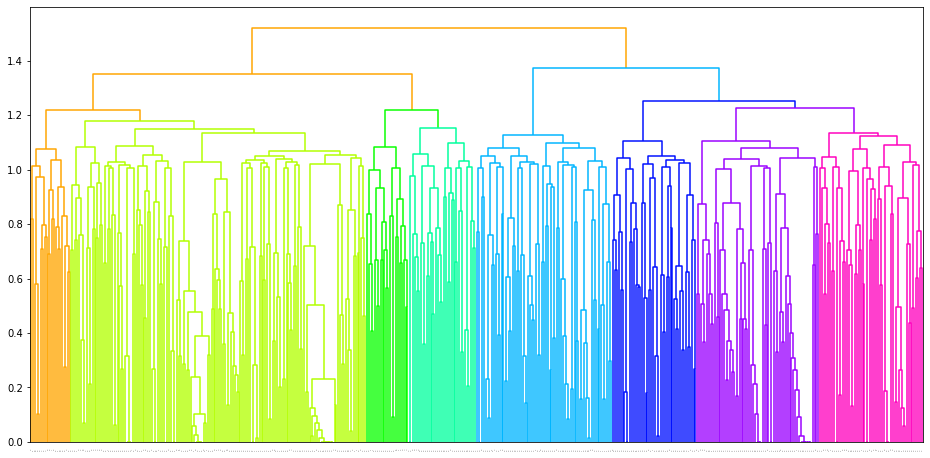

In [4]:
fig_tree = mp.plot_tree(add_leaf_labels = False, leaf_font_size = 1)
fig_tree.savefig(os.path.join(save_dir, 'tree.png'), bbox_inches='tight', dpi=300)

# 10FCV

In [5]:
gpuid = 6

outer_fold = 10
repeat_seeds = [8, 16, 32, 64, 128, 256, 1024, 2048, 4096, 8192] #10 repeats random seeds 8, 16, 32, 64, 128

each_fold_results = []
run_all_res = []

for i, repeat_seed in enumerate(repeat_seeds): 
    outer = StratifiedKFold(n_splits = outer_fold, shuffle = True, random_state = repeat_seed)
    outer_idx = outer.split(range(len(dfy)), dfy.idxmax(axis=1))
    run_one_res = []
    one_repeat_results = []
    for j, idx in enumerate(outer_idx):
        fold_num = "fold_%s" % str(j).zfill(2) 
        print('#'*50 + ' repeat_seed: %s; %s ' % (repeat_seed, fold_num) + '#'*50 )
        
        train_idx, test_idx = idx

        testY = Y[test_idx]
        testX = X[test_idx]
        
        trainX = X[train_idx]
        trainY = Y[train_idx]

        print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

        clf = AggModel.MultiClassEstimator(epochs = 50,  batch_size = 2, verbose = 0, gpuid=gpuid) #
        clf.fit(trainX, trainY)  #, 
        
        ## save model for explaination
        if i == 0:
            clf.save_model(os.path.join(save_dir, '%s.model' % fold_num))
            paras = clf.get_params()
            paras.update({'featHPs':featHPs})
            pd.Series(paras).to_json(os.path.join(save_dir, 'HPs.json'))

        pred_proba = clf.predict_proba(testX)
        y_true = testY[:,1] 
        y_score = pred_proba[:,1]
        y_pred = np.argmax(pred_proba, axis=1)
        
        dfr = pd.DataFrame([y_true, y_score, y_pred]).T
        dfr.columns = ['y_true', 'y_score', 'y_pred']
        dfr.index = dfy.iloc[test_idx].index
        auc, mcc, pres, recall, f1  = score(dfr)
        run_one_res.append(dfr)
        ts = pd.Series([auc, mcc, pres, recall, f1, i, repeat_seed]).round(3)
        ts.index = ['auc', 'mcc', 'pres', 'recall', 'f1', 'i', 'repeat_seed']
        print(ts.to_dict())
        each_fold_results.append(ts.to_dict())    
        one_repeat_results.append(ts.to_dict())
    print('\n\nresults for seed %s' % repeat_seed)
    print(pd.DataFrame(one_repeat_results).mean().to_dict())
    
    run_all_res.append(pd.concat(run_one_res))

################################################## repeat_seed: 8; fold_00 ##################################################

 input train and test X shape is (227, 22, 22, 8), (26, 22, 22, 8) 
saving model to Obesity_results/fold_00.model
roc-auc: 0.595, mcc: 0.150, pres: 0.615, recall: 0.615, f1: 0.615
{'auc': 0.595, 'mcc': 0.15, 'pres': 0.615, 'recall': 0.615, 'f1': 0.615, 'i': 0.0, 'repeat_seed': 8.0}
################################################## repeat_seed: 8; fold_01 ##################################################

 input train and test X shape is (227, 22, 22, 8), (26, 22, 22, 8) 
saving model to Obesity_results/fold_01.model
roc-auc: 0.745, mcc: 0.320, pres: 0.692, recall: 0.692, f1: 0.692
{'auc': 0.745, 'mcc': 0.32, 'pres': 0.692, 'recall': 0.692, 'f1': 0.692, 'i': 0.0, 'repeat_seed': 8.0}
################################################## repeat_seed: 8; fold_02 ##################################################

 input train and test X shape is (227, 22, 22, 8), (2

In [6]:
pd.DataFrame(each_fold_results).groupby('repeat_seed').mean().mean()

auc       0.64242
mcc       0.19896
pres      0.63715
recall    0.65173
f1        0.63554
i         4.50000
dtype: float64

In [7]:
pd.DataFrame(each_fold_results).groupby('repeat_seed').std().mean()

auc       0.113380
mcc       0.199374
pres      0.095793
recall    0.081050
f1        0.087811
i         0.000000
dtype: float64

In [8]:
pd.DataFrame(each_fold_results).to_csv(os.path.join(save_dir, 'performance_results.csv'))

# feature importance

In [24]:
all_imps = []
for i in range(10):
    clf = load_model(os.path.join(save_dir, 'fold_%s.model' % str(i).zfill(2)))
    dfe = clf.explain_model(mp, clf.X_, clf.y_, binary_task=True, apply_logrithm=False)
    df_imp = dfe.col_1_importance.to_frame(name = 'fold_%s_imp' % str(i).zfill(2))
    all_imps.append(df_imp)

  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


  0%|          | 0/484 [00:00<?, ?it/s]

calculating feature importance for column 1 ...


100%|##########| 484/484 [00:14<00:00, 32.35it/s]


In [25]:
dfi = dfe[dfe.columns[:-1]]
dfi['scatter_x'] = dfi.v.map(mp.df_embedding.x)
dfi['scatter_y'] = dfi.v.map(mp.df_embedding.y)

dfimp_all = pd.concat(all_imps, axis=1)
dfi = dfi.join(dfimp_all.mean(axis=1).to_frame(name = 'avg_imp'))
dfi = dfi.join(dfimp_all)
dfi.to_csv(os.path.join(save_dir, 'feature_imp_results.csv'))

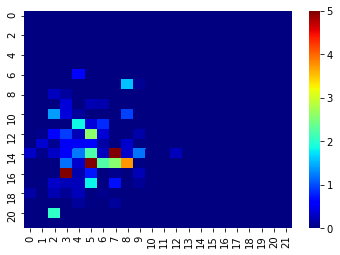

In [29]:
sns.heatmap(dfi.avg_imp.values.reshape(*mp.fmap_shape), vmin=0, vmax=5, cmap = 'jet')

In [33]:
dfi.avg_imp.sort_values(ascending=False).head(20)

355    16.120526
335     6.987221
315     5.575095
338     3.741903
269     2.613542
337     2.577776
336     2.228910
313     2.212121
442     2.031295
246     1.840159
379     1.823118
162     1.563421
222     1.391112
312     1.219480
317     1.196944
333     1.181315
228     0.938736
267     0.929964
248     0.821031
357     0.733433
Name: avg_imp, dtype: float64